In [46]:
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import itertools
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import plotly.graph_objects as go

import copy
%matplotlib inline

from src.nets import Nets
from src.utils import *
from src.postprocessing.postprocessing import *
from src.postprocessing.stats_plotting import *
from src.postprocessing.interpolation import *

from src.save_load import *

from src.training_utils import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
COLOR_CENTER = "gold"
COLOR1 = "thistle" 
COLOR2 = "lightsalmon" 
COLOR3 = "skyblue" 

In [48]:
root_folder = os.environ["PATH_TO_GENNI_FOLDER"]
exp = ""
experiment_folder = os.path.join(root_folder, "experiments", exp)

In [51]:
cache_dict = {}


In [52]:

exp_id = ""


device = None
cfg = cfgs.loc[exp_id]
cfg["data_meta"]["N"] = 500
cache_dict["N"] = cfg["data_meta"]["N"]

data_set = get_data(cfg, device=device)
data_loader = DataLoader(data_set, batch_size=cfgs.loc[exp_id]["batch_size"], shuffle=False)

criterion = torch.nn.MSELoss()


In [53]:
all_steps = get_exp_steps(experiment_folder)
all_steps = np.array([list(v.keys()) for v in all_steps.values()]).reshape(-1)
all_steps = sorted(list(set(all_steps)))

# Plot in 2D

In [ ]:
# Init 2D affine subspace

# Center model 
center_step = 1001
center_idx = 0

center_model = get_all_models(experiment_folder, center_step)[exp_id][str(center_idx)]

cache_dict["center_config"] = {
    "step": center_step,
    "idx": center_idx
}

# Get models
model_steps = [1001, 1001]
model_idxs = [1, 2]

basis_vectors = [get_params_vec(get_all_models(experiment_folder, model_steps[i])[exp_id][str(model_idxs[i])]) 
                 for i in range(len(model_steps))]

cache_dict["basis_vectors_config"] = {
    "steps": model_steps,
    "model_idxs": model_idxs
}

basis_orthonorm_vectors = create_offset_orthonorm_basis(center_model, basis_vectors)
basis_orthonorm_vectors = [torch.Tensor(v) for v in basis_orthonorm_vectors]

c1 = get_coordinates(basis_vectors[0], basis_orthonorm_vectors, get_params_vec(center_model))
c2 = get_coordinates(basis_vectors[1], basis_orthonorm_vectors, get_params_vec(center_model))
cO = [0, 0]

l1 = get_net_loss(vec_to_net(basis_vectors[0], center_model), data_loader, criterion, full_dataset=True)
l2 = get_net_loss(vec_to_net(basis_vectors[1], center_model), data_loader, criterion, full_dataset=True)
lO = get_net_loss(center_model, data_loader, criterion, full_dataset=True)

cache_dict["basis_orthonorm_vectors"] = basis_orthonorm_vectors

In [ ]:
# Get grid losses

num_inter_models = 100
grid_bound = [-13, 13]
cache_dict["num_inter_models"] = num_inter_models
cache_dict["grid_bound"] = grid_bound

func = lambda m: get_net_loss(m, data_loader, criterion, full_dataset=True, device=None)

two_d_vals = get_model_interpolate_grid(center_model, basis_orthonorm_vectors, num_inter_models, grid_bound, func)


grid_arr = np.linspace(grid_bound[0], grid_bound[1], num_inter_models)
cache_data(experiment_folder, "2d_loss", two_d_vals, meta_dict=cache_dict, time_stamp=True)

In [ ]:
# UNCOMMENT TO LOAD CACHED GRID POINTS

# two_d_vals, meta_data = load_cached_data(experiment_folder, "2d_loss", time_stamp="")
# print(meta_data)

# grid_bound = meta_data["grid_bound"]
# num_inter_models = meta_data["num_inter_models"]
# basis_orthonorm_vectors = meta_data["basis_orthonorm_vectors"]

# grid_arr = np.linspace(grid_bound[0], grid_bound[1], num_inter_models)

In [ ]:
# filter vals 
vals_filtered = np.array(two_d_vals)
vals_filtered[vals_filtered > 0.003] = None

grid_arr = np.linspace(grid_bound[0], grid_bound[1], num_inter_models)


In [ ]:
# Surface Plot

fig = go.Figure(data=[go.Surface(z=vals_filtered + 0, x=grid_arr, y=grid_arr, colorscale="viridis", name='J(' + 'θ' + ')', cmax=0.001, cmin=0,
                                 colorbar=dict(thickness=130, title='J(' + 'θ' + ')', titlefont=dict(size=80), lenmode="fraction", len=0.80, x=0.78, y=0.45, tickfont=dict(size=70))),
                     go.Scatter3d(x=np.array([0]), y=np.array([0]), z=[0.0 + lO],  mode="markers", marker=dict(size=20, color=[COLOR_CENTER]), showlegend=False,),
                     go.Scatter3d(x=np.array([c1[0]]), y=np.array([c1[1]]), z=[0.0 + l1], mode="markers", marker=dict(size=20, color=[COLOR1]), showlegend=False,),
                     go.Scatter3d(x=np.array([c2[0]]), y=np.array([c2[1]]), z=[0.0 + l2], mode="markers", marker=dict(size=20, color=[COLOR2]), showlegend=False,) ])

fig.update_layout(title=None, autosize=False,
                  width=1280, height=720,
                  font=dict(
                        size=27,
                ),
                  scene={"zaxis": dict(title='J(' + '\u03B8' + ')', titlefont=dict(size=80), range=[0,0.001], tickmode = 'linear', tick0 = 0, dtick = 0.001, tickangle=0, ticks='outside', tickwidth=0),
                         "xaxis": dict(range=[-10, 14], title="c1", titlefont=dict(size=80),   tickmode = 'array', tickvals=[-8, 13], tickangle=0, ticks='outside', tickwidth=0), 
                         "yaxis": dict(range=[-14, 11], title="c2", titlefont=dict(size=80), tickmode = 'array', tickvals=[-13, 10], tickangle=0)})


fig.show()


In [ ]:
# Contour Plot

fig = go.Figure(data = [go.Contour( z=np.log(vals_filtered), x=grid_arr, y=grid_arr, colorscale="viridis",
                                   colorbar=dict(title="log({})".format('J(' + '\u03B8' + ')'))), 
                       go.Scatter(x=np.array(0), y=np.array(0), marker=dict(color=COLOR_CENTER, size=12), showlegend=False,),
                       go.Scatter(x=np.array([c1[0]]), y=np.array([c1[1]]), marker=dict(color=COLOR1, size=12), showlegend=False,),
                       go.Scatter(x=np.array([c2[0]]), y=np.array([c2[1]]), marker=dict(color=COLOR2, size=12), showlegend=False,)]
               )

fig.update_layout(title='', autosize=False,
                  font=dict(
                        size=22,
                    ),
                  paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                  width=800, height=600, 
                 xaxis=dict(title="c1"),
                 yaxis=dict(title="c2"))


fig.show()


# Plot in 3D

In [ ]:
# config set up

# Center model 
cache_dict["center_config"] = {
    "step": 1001,
    "idx": 0
}

# Basis Vectors
cache_dict["basis_vectors_config"] = {
    "steps": [1001, 1001, 1001], 
    "model_idxs": [1, 2, 3]
}

cache_dict["num_inter_models"] = 35
cache_dict["grid_bound"] = [-13, 13]

In [54]:

# Center model 
center_step = 1001
center_idx = 0

center_model = get_all_models(experiment_folder, center_step)[exp_id][str(center_idx)]

cache_dict["center_config"] = {
    "step": 1001,
    "idx": 0
}

# Manually get models
model_steps = [1001, 1001, 1001]
model_idxs = [1, 2, 3]

basis_vectors = [get_params_vec(get_all_models(experiment_folder, model_steps[i])[exp_id][str(model_idxs[i])]) 
                 for i in range(len(model_steps))]

cache_dict["basis_vectors_config"] = {
    "steps": model_steps,
    "model_idxs": model_idxs
}

basis_orthonorm_vectors = create_offset_orthonorm_basis(center_model, basis_vectors)
basis_orthonorm_vectors = [torch.Tensor(v) for v in basis_orthonorm_vectors]

cache_dict["basis_orthonorm_vectors"] = basis_orthonorm_vectors

c1 = get_coordinates(basis_vectors[0], basis_orthonorm_vectors, get_params_vec(center_model))
c2 = get_coordinates(basis_vectors[1], basis_orthonorm_vectors, get_params_vec(center_model))
c3 = get_coordinates(basis_vectors[2], basis_orthonorm_vectors, get_params_vec(center_model))

cO = [0, 0, 0]

l1 = get_net_loss(vec_to_net(basis_vectors[0], center_model), data_loader, criterion, full_dataset=True)
l2 = get_net_loss(vec_to_net(basis_vectors[1], center_model), data_loader, criterion, full_dataset=True)
l3 = get_net_loss(vec_to_net(basis_vectors[2], center_model), data_loader, criterion, full_dataset=True)

lO = get_net_loss(center_model, data_loader, criterion, full_dataset=True)

In [ ]:
num_inter_models = 35
grid_bound = [-13, 13]
cache_dict["num_inter_models"] = num_inter_models
cache_dict["grid_bound"] = grid_bound

func = lambda m: get_net_loss(m, data_loader, criterion, full_dataset=True, device=None)

grid = get_models_grid(center_model, basis_orthonorm_vectors, num_inter_models, grid_bound)
three_d_vals = get_model_interpolate_grid(center_model, basis_orthonorm_vectors, num_inter_models, grid_bound, func)
cache_data(experiment_folder, "3d_loss", three_d_vals, meta_dict=cache_dict, time_stamp=True)

In [63]:
# UNCOMMENT TO LOAD CACHED GRID POINTS

# three_d_vals, meta_data = load_cached_data(experiment_folder, "3d_loss", time_stamp="")

# grid_bound = meta_data["grid_bound"]
# num_inter_models = meta_data["num_inter_models"]
# basis_orthonorm_vectors = meta_data["basis_orthonorm_vectors"]

# grid_arr = np.linspace(grid_bound[0], grid_bound[1], num_inter_models)

# grid = get_models_grid(center_model, basis_orthonorm_vectors, num_inter_models, grid_bound)


53it [00:00, 521.46it/s]

{'N': 500, 'basis_orthonorm_vectors': [tensor([-0.0070, -0.0176, -0.0041,  ...,  0.0139,  0.0100,  0.0107]), tensor([-0.0080, -0.0083,  0.0170,  ...,  0.0027, -0.0101, -0.0012]), tensor([ 0.0080,  0.0026, -0.0118,  ...,  0.0086,  0.0134, -0.0115])], 'basis_vectors': 'trained', 'basis_vectors_config': {'model_idxs': [1, 2, 3], 'steps': [1001, 1001, 1001]}, 'center_config': {'idx': 0, 'step': 1001}, 'grid_bound': [-13, 13], 'num_inter_models': 35}


42875it [01:04, 669.40it/s]


In [65]:
grid_filter = three_d_vals.reshape(-1) <  0.0025

In [66]:
# First dim is z axis, and last dimension x axis. This is because of how we need to loop (from last basis vector to first)
grid_coeffs = itertools.product(np.linspace(grid_bound[0], grid_bound[1], num_inter_models), repeat=len(basis_vectors))
grid_coeffs = np.array(list(grid_coeffs))[grid_filter]


In [ ]:

fig = go.Figure(data=[go.Scatter3d(z=grid_coeffs[:, 0], x=grid_coeffs[:, 2], y=grid_coeffs[:, 1], mode='markers',
                    marker=dict(
                        size=10,
                        color=three_d_vals.reshape(-1)[grid_filter],
                        colorscale='viridis',   # choose a colorscale
                        opacity=1,# ))])
                        colorbar=dict(thickness=130, title='J(' + '\u03B8' + ')', titlefont=dict(size=80), lenmode="fraction", len=0.80, x=0.78, y=0.55, tickfont=dict(size=70))))])


fig.update_layout(title=None, autosize=False,
                  width=1280, height=720,
                  font=dict(
                        size=27,
                ),
                  scene={"zaxis": dict(title='c3', titlefont=dict(size=80),),
                         "xaxis": dict(title="c1", titlefont=dict(size=80)), 
                         "yaxis": dict(title="c2", titlefont=dict(size=80))})

fig.show()

### UMAP Plot

In [68]:
# Fit umap 

fit = umap.UMAP(n_neighbors=200, min_dist=0.5, metric='euclidean', verbose=True)


In [70]:
# add the basis vectors 
filtered_grid = grid.reshape(np.prod(grid.shape[:-1]), -1)[grid_filter]
filtered_grid = np.concatenate([filtered_grid, [get_params_vec(center_model).detach().numpy()], [b.detach().numpy() for b in basis_vectors]])

u = fit.fit_transform(filtered_grid)

UMAP(min_dist=0.5, n_neighbors=200, verbose=True)
Construct fuzzy simplicial set
Wed Oct 14 00:35:21 2020 Finding Nearest Neighbors
Wed Oct 14 00:35:21 2020 Building RP forest with 13 trees
Wed Oct 14 00:36:02 2020 NN descent for 15 iterations
	 0  /  15
	 1  /  15
Wed Oct 14 00:41:57 2020 Finished Nearest Neighbor Search
Wed Oct 14 00:42:11 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Oct 14 00:42:24 2020 Finished embedding


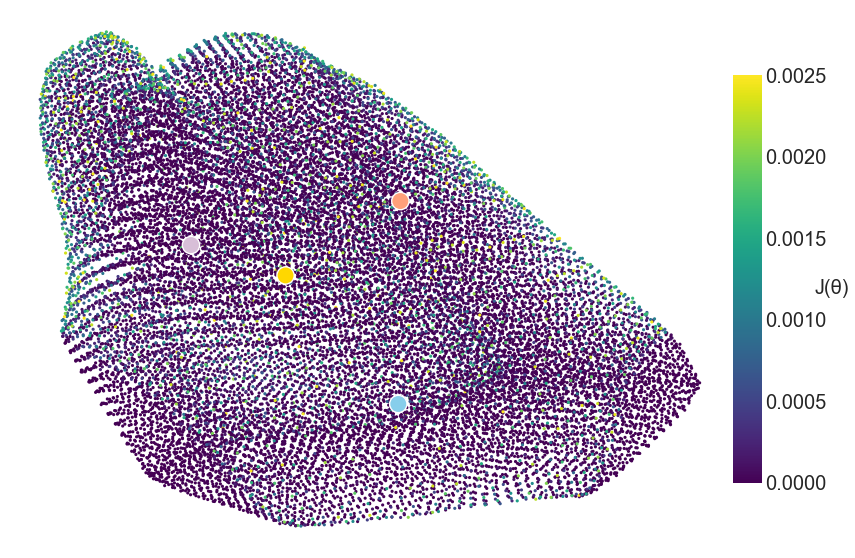

In [71]:
# Merge fit with labels
labels = np.concatenate([three_d_vals.reshape(-1)[grid_filter], [lO, l1, l2, l3]])

dataset = pd.DataFrame({'x1': u[:-4, 0], 'x2': u[:-4, 1], 'label': labels[:-4]})

# Plot
sns.set(font_scale=1.4, rc={'figure.figsize':(13, 10)})
sns.set_style("white", {'axes.spines.left': False,
                         'axes.spines.bottom': False,
                         'axes.spines.right': False,
                         'axes.spines.top': False})
ax = sns.scatterplot(x="x1", y="x2", hue="label",
                     data=dataset,
                     s=10,
                     palette='viridis', 
                     edgecolor="none")

ax = sns.scatterplot(x=u[-4:, 0], y=u[-4:, 1],
                     s=300, hue=[COLOR_CENTER, COLOR1, COLOR2, COLOR3], palette=[COLOR_CENTER, COLOR1, COLOR2, COLOR3])

ax.set(yticks=[], xticks=[], xlabel='', ylabel='')
ax.get_legend().remove()

norm = plt.Normalize(0, 0.0025)
# norm = plt.Normalize(dataset['label'].min() - 0.00001, dataset['label'].max() + 0.00001)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="2%", pad=0.5)
cax = inset_axes(ax,
                   width="4%",  # width = 5% of parent_bbox width
                   height="75%",  # height : 50%
                   loc='center left',
                   bbox_to_anchor=(1, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
cbar = ax.figure.colorbar(sm, cax=cax, )
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('J(' + '\u03B8' + ')', rotation=0, size=20)

ax.get_figure().savefig(os.path.join(image_folder, "UMAP_3d.pdf"), bbox_inches = 'tight', pad_inches = 0)
